# Import các thư viện cần thiết

In [80]:
pip install emoji

In [81]:
pip install datasets

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import re
import emoji
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler


# Đọc dữ liệu và Phân tích sơ bộ

### Đọc dữ liệu

In [83]:
data = pd.read_csv("/content/drive/MyDrive/Tự học/NLP/NLP DS/data.csv")

In [84]:
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


### Thống kê cơ bản

In [85]:
print("Số hàng của tập dữ liệu là (Số lượng mẫu):", data.shape[0])
print("Số cột của tập dữ liệu là:", data.shape[1])

Số hàng của tập dữ liệu là (Số lượng mẫu): 5842
Số cột của tập dữ liệu là: 2


In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


- Với thông tin ở trên ta thấy tập dữ liệu không có cột nào bị thiếu dữ liệu

In [87]:
print("Số bản ghi bị trùng lặp:", data.duplicated().sum())

Số bản ghi bị trùng lặp: 6


In [88]:
# Ta thực hiện việc xóa các bản ghi này trên tập dữ liệu trực tiếp
data.drop_duplicates(inplace= True, keep= "first")
# Thực hiện việc kiểm tra lại
data.duplicated().sum()

0

Phân phối nhãn:
Sentiment
neutral     3124
positive    1852
negative     860
Name: count, dtype: int64


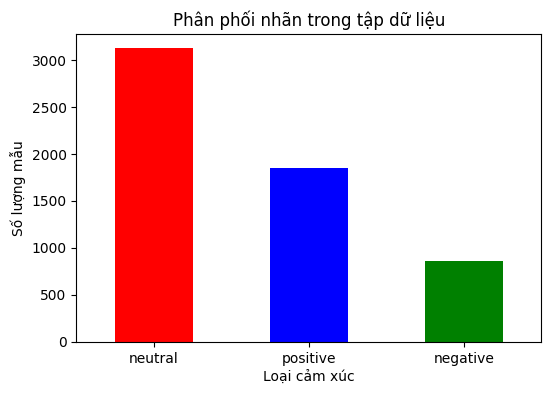

In [89]:
# Kiểm tra phân phối nhãn
label_distribution = data["Sentiment"].value_counts()
print("Phân phối nhãn:")
print(label_distribution)

# Vẽ biểu đồ phân phối nhãn
plt.figure(figsize=(6,4))
label_distribution.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title("Phân phối nhãn trong tập dữ liệu")
plt.xlabel("Loại cảm xúc")
plt.ylabel("Số lượng mẫu")
plt.xticks(rotation=0)
plt.show()


Thống kê cơ bản về độ dài câu:
count    5836.000000
mean       20.995888
std        10.291084
min         2.000000
25%        13.000000
50%        19.000000
75%        27.000000
max        81.000000
Name: Sentence, dtype: float64


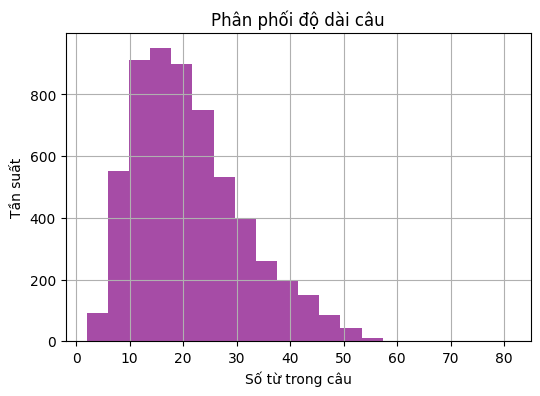

In [90]:
# Thống kê cơ bản
print("\nThống kê cơ bản về độ dài câu:")
sentence_length = data["Sentence"].apply(lambda x: len(x.split()))
print(sentence_length.describe())

# Vẽ biểu đồ histogram độ dài câu
plt.figure(figsize=(6,4))
sentence_length.hist(bins=20, color='purple', alpha=0.7)
plt.title("Phân phối độ dài câu")
plt.xlabel("Số từ trong câu")
plt.ylabel("Tần suất")
plt.show()

# Làm sạch dữ liệu

In [91]:
data.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


Sau khi kiểm tra dữ liệu em thấy có một số mã cổ phiếu có ký tự đặc biệt, các link url, khoảng trắng và emoji.

In [92]:
def clean_text(text):
  '''
  Hàm trên được viết để thực hiện việc xóa các ký tự đặc biệt như các mã cổ phiếu, Url,... trong tập dữ liệu
  '''
  text = text.lower()  # Chuyển về chữ thường
  text = re.sub(r'\$[A-Za-z0-9]+', '', text)  # Loại bỏ ký hiệu cổ phiếu ($ESI, $SPY, etc.)
  text = re.sub(r'http\S+|www\.\S+', '', text)  # Loại bỏ URL
  text = re.sub(r'[^a-zA-Z\s]', '', text)  # Loại bỏ ký tự đặc biệt (giữ lại khoảng trắng và chữ cái)
  text = emoji.replace_emoji(text, replace='')  # Loại bỏ emoji
  text = re.sub(r'\s+', ' ', text).strip()  # Loại bỏ khoảng trắng thừa
  return text

In [93]:
data["Sentence"] = data["Sentence"].apply(clean_text)

In [94]:
data.head(10)

,Sentence,Sentiment
0,the geosolutions technology will leverage bene...,positive
1,on lows down to bk a real possibility,negative
2,for the last quarter of componenta s net sales...,positive
3,according to the finnishrussian chamber of com...,neutral
4,the swedish buyout firm has sold its remaining...,neutral
5,wouldnt be surprised to see a green close,positive
6,shells billion bg deal meets shareholder skept...,negative
7,ssh communications security corp stock exchang...,negative
8,kone s net sales rose by some yearonyear in th...,positive
9,the stockmann department store will have a tot...,neutral


# Fine Tuning model 1

In [95]:
model_path = "/content/drive/MyDrive/Tự học/NLP/NLP DS"


In [96]:
# Kiểm tra GPU
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU available: True
GPU name: Tesla T4


In [97]:
# Mã hóa nhãn thành số
# Vì labels hiện tại vẫn đang là chữ vì thế cần mã hóa thành các số để có thể tiện cho việc training
label_map = {"negative": 0, "neutral": 1, "positive": 2}
data["Sentiment"] = data["Sentiment"].map(label_map)

In [98]:
# Chia tập dữ liệu thành huấn luyện (80%) và kiểm tra (20%)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data["Sentence"].tolist(), data["Sentiment"].tolist(), test_size=0.2, random_state=42
)

In [99]:
# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

In [100]:
# Chuyển dữ liệu thành Dataset của Hugging Face
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": torch.tensor(train_labels)
})

In [101]:
val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": torch.tensor(val_labels)
})

In [111]:
# Load mô hình
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
model.to(device)

# Cấu hình huấn luyện
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

train_result = trainer.train()
train_loss_history = []
eval_loss_history = []

# Lấy loss
log_history = trainer.state.log_history
for log in log_history:
    if "loss" in log:
        train_loss_history.append(log["loss"])
    if "eval_loss" in log:
        eval_loss_history.append(log["eval_loss"])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.516170
2,0.514600,0.488828
3,0.514600,0.634347
4,0.252100,0.851005
5,0.252100,0.854787
6,0.178100,0.972483
7,0.146900,0.970826
8,0.146900,1.011348
9,0.133700,1.151426
10,0.133700,1.185577


- Traning loss đang giảm điều này cho thấy mô hình đang học được từ tập dữ liệu
- validation loss tăng từ epoch 3 điều này cho thấy mô hình đang học quá kỹ từ tập dữ liệu
- Traning loss rất nhỏ so với validation loss (overfiting rất nặng)
- Sử dụng drop_out để hoặc weight_deplay lớn hơn

In [114]:
# Lưu mô hình
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/Tự học/NLP/NLP DS/tokenizer_config.json',
 '/content/drive/MyDrive/Tự học/NLP/NLP DS/special_tokens_map.json',
 '/content/drive/MyDrive/Tự học/NLP/NLP DS/vocab.txt',
 '/content/drive/MyDrive/Tự học/NLP/NLP DS/added_tokens.json')

Accuracy: 0.7637
Precision: 0.7678, Recall: 0.7637, F1-score: 0.7656


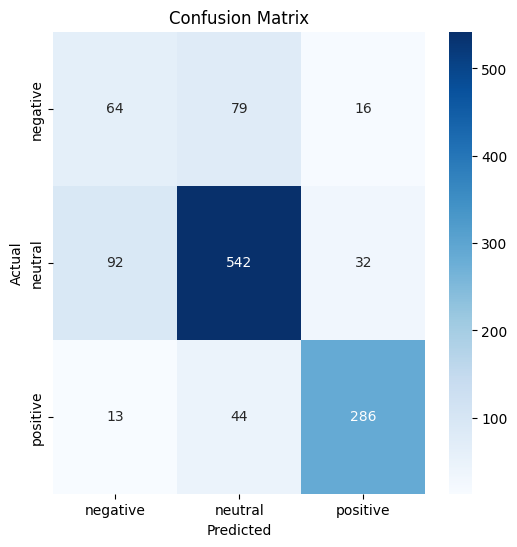

In [115]:
# Đánh giá mô hình
predictions = trainer.predict(val_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), axis=-1).numpy()
labels = torch.tensor(predictions.label_ids).numpy()

# Tính Accuracy, Precision, Recall, F1-score
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Vẽ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

- Mô hình có độ chính xác khá tốt nhưng có xu hướng nhầm lẫn giữa Negative - Neutral và Neutral - Positive.  
- Neutral có số lượng dự đoán chính xác cao nhất (542 mẫu) nhưng vẫn bị nhầm lẫn với cả Negative và Positive.
- Negative bị nhầm nhiều thành Neutral (79 mẫu)
=> Thử cân  bằng dữ liệu lại để train lại xem kết quả như thế nào

# Fine tuning model 2

In [127]:
model_path_2 = "/content/drive/MyDrive/Tự học/NLP/NLP DS/Model 2"


In [117]:
# Cân bằng dữ liệu bằng Random OverSampling
X = data["Sentence"]
y = data["Sentiment"]
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)
data_balanced = pd.DataFrame({"Sentence": X_resampled.flatten(), "Sentiment": y_resampled})


In [118]:
# Chia tập dữ liệu
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data_balanced["Sentence"].tolist(), data_balanced["Sentiment"].tolist(), test_size=0.2, random_state=42
)


In [119]:
# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

In [120]:
# Chuyển dữ liệu thành Dataset của Hugging Face
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": torch.tensor(train_labels)
})

In [121]:
val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": torch.tensor(val_labels)
})

- Vì model lần trước gặp tình trạng overfiting nên ở lần train lại lần này tôi sẽ giảm số epochs xuống còn 5 và tăng weight_decay = 0.1:

In [124]:
# Load mô hình
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
model.to(device)

# Cấu hình huấn luyện
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.1,
    logging_dir="./logs",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

train_result = trainer.train()
train_loss_history = []
eval_loss_history = []

# Lấy loss
log_history = trainer.state.log_history
for log in log_history:
    if "loss" in log:
        train_loss_history.append(log["loss"])
    if "eval_loss" in log:
        eval_loss_history.append(log["eval_loss"])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.397837
2,0.538200,0.380844
3,0.279200,0.391265
4,0.197500,0.425725
5,0.169500,0.466657


- Lần này training loss vẫn giảm chứng tỏ mô hình đã học được từ dữ liệu
- validation loss vẫn có dấu hiệu tăng nhưng nó đã tăng chậm hơn so với lần train đầu tiên
- Chênh lệch giữa training loss và validation loss chênh lệch không quá nhiều - đã giảm được hiện tượng overfiting

In [128]:
# Lưu mô hình
model.save_pretrained(model_path_2)
tokenizer.save_pretrained(model_path_2)

('/content/drive/MyDrive/Tự học/NLP/NLP DS/Model 2/tokenizer_config.json',
 '/content/drive/MyDrive/Tự học/NLP/NLP DS/Model 2/special_tokens_map.json',
 '/content/drive/MyDrive/Tự học/NLP/NLP DS/Model 2/vocab.txt',
 '/content/drive/MyDrive/Tự học/NLP/NLP DS/Model 2/added_tokens.json')

Accuracy: 0.8901
Precision: 0.8968, Recall: 0.8901, F1-score: 0.8884


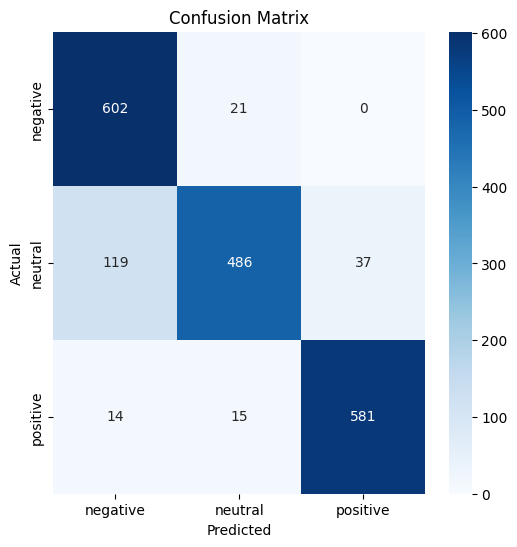

In [130]:
# Đánh giá mô hình
predictions = trainer.predict(val_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), axis=-1).numpy()
labels = torch.tensor(predictions.label_ids).numpy()

# Tính Accuracy, Precision, Recall, F1-score
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Vẽ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

- Mô hình lần này có độ chính xác cao hơn đáng kể so với lần train đầu tiên
- Mô hình có sự cân bằng tốt giữa precision và recall
- Lớp "Negative" (Tiêu cực) 602 mẫu được dự đoán đúng trên tổng số 623 mẫu (96.6%). 21 mẫu bị nhầm thành Neutral, nhưng không có mẫu nào bị nhầm thành Positive=> Tốt hơn nhiều so với trước, khi Negative bị nhầm lẫn rất nhiều.
- Lớp "Neutral" (Trung lập) 486 mẫu được dự đoán đúng, nhưng 119 mẫu bị nhầm thành Negative, 37 mẫu bị nhầm thành Positive.
- Lớp "Positive" (Tích cực) 581 mẫu được dự đoán đúng trên tổng số 610 mẫu (95.2%). Chỉ có 15 mẫu bị nhầm thành Neutral, 14 mẫu bị nhầm thành Negative.
=> Mô hình phân loại Positive rất tốt.


# So sánh


| **Chỉ số**        | **Trước (76.37%)** | **Hiện tại (89.01%)** | **Cải thiện** |
|-------------------|-----------------|-----------------|------------|
| **Accuracy**     | 76.37%          | 89.01%          |  +12.64% |
| **Negative (TN)** | 64 đúng        | 602 đúng        |  Cải thiện rõ rệt |
| **Neutral (TN)**  | 542 đúng       | 486 đúng       |  Giảm nhẹ (cần tối ưu thêm) |
| **Positive (TP)** | 286 đúng       | 581 đúng       |  Cải thiện mạnh |


# Xây dựng api và giaod iện người dùng